# Capstone Project - The Battle of Neighborhoods (Week2)

#### Applied Data Science Capstone by IBM/Coursera

## Introduction : Business Problem
In this project we will try to help decision makers on finding the potential neighborhoods to launch new hotel. 

Bangkok is the capital of Thailand. Before the pandemic began, Bangkok was one of the world’s top tourist destination cities. Each year approximately 22.7 million international visitors arrive in Bangkok. Also, MasterCard ranked Bangkok as the top destination for global travelers. Till now, there are millions of people have been vaccinated around the world. The travelling will be return soon.  To serve the travelers around the world are looking forward to visiting Bangkok, the lodging is dedicated to perfecting the travel experience. 

This project aims to provide the stakeholder with necessary information for example, name and location of Bangkok districts and the number of hotels in each district. Also, generate hotel maps in Bangkok

In [1]:
# Import necessary library
import json
import requests
import pandas as pd
import numpy as np
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
#import k-means from clustering stage
from sklearn.cluster import KMeans


## Data
Based on definition of our problem and the aim of this project the following sources will be used for analysis
- The list of districts get from this https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok  link. This link we can get the latitude and longitude of each district, district name in both English and local language, population and district code
- Venue data from Foursquare API, particular data related to hotel. I will use this data to perform clustering on the districts
- Plot district maps and hotels map 

### Data extraction and data cleansing

#### Extract Wikipedia data

pandas.io.html is web scraping technique which use to extract the data from Wikipedia page

In [2]:
from pandas.io.html import read_html
url='https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok'
wikitable = read_html(url,  attrs={"class":"wikitable"},header =0)
wiki_df = pd.DataFrame(wikitable[0])
wiki_df= wiki_df.rename(columns={'District(Khet)':'DistrictEng'})
wiki_df= wiki_df.rename(columns={'MapNr':'code'})
wiki_df= wiki_df.rename(columns={'Post-code':'Postcode'})
wiki_df= wiki_df.rename(columns={'Thai':'District'})
wiki_df= wiki_df.rename(columns={'Popu-lation':'Population'})
wiki_df= wiki_df.rename(columns={'No. ofSubdis-trictsKhwaeng':'No_of_Subdistricts'})
wiki_df.head()

,DistrictEng,code,Postcode,District,Population,No_of_Subdistricts,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500


In [3]:
geolocator = Nominatim(user_agent="foursquare_agent")

In [4]:
#checking the number of districts in Bangkok
wiki_df.shape

(50, 8)

In [5]:
#Checking the total popluation
wiki_df['Population'].sum()

5671070

In [6]:
address = "Bangkok, Thailand"
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude   #13.8429682 # location.latitude 
longitude =location.longitude #100.5542001# location.longitude #
kan ='Bangkok location : {},{}'.format(latitude,longitude)
print(kan)

Bangkok location : 13.7544238,100.4930399


## Geranate district map

### Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods
Red circle represents the central area of Bangkok. Size of green circle represent population in each district

In [7]:
map_bangkok = folium.Map(location=[latitude, longitude], zoom_start=10)  # generate map centred around the Bangkok
# add a red circle marker to represent the core location of Bangkok
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Bangkok',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_bangkok)

for lat, long, dist, code, pop in zip(wiki_df.Latitude, wiki_df.Longitude, wiki_df.District, \
                                      wiki_df.code, wiki_df.Population):
    label = '{}, {}'.format(code, dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=pop/10000,
        popup=label,
        color='green',
        fill=True,
        fill_color='#00FF00',
        fill_opacity=0.6,
        parse_html=False).add_to(map_bangkok)  

# display map
map_bangkok

## Foursquare

###  Define client_id and client_secret 

In [8]:
CLIENT_ID = 'LLKHDPW3ABIQPV4AX3NCWOZO30GBDXEZL4OWOW13XQQCH44H' # your Foursquare ID
CLIENT_SECRET = 'ARK4KVCOIDNDO3MRFZEHSE2ZU10WHZQFJZEJ3MIQTSAVQJPI' # your Foursquare Secret
VERSION = '20191028'

In [9]:
radius = 5000
LIMIT = 100

venues = []

for lat, long, dist, code,pop in zip(wiki_df.Latitude, wiki_df.Longitude, wiki_df.District, wiki_df.code, wiki_df.Population):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    for venue in results:
        venues.append((
            dist, 
            code,
            pop,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['id'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [10]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['District', 'Population', 'Code', 'Latitude', 'Longitude', 'VenueName','VenueId', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
venues_df

,District,Population,Code,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueCategory
0,บางบอน,50,105161,13.659200,100.399100,ขาหมูบางหว้า,4e880a81f790e992e01d7284,13.657136,100.395230,Thai Restaurant
1,บางบอน,50,105161,13.659200,100.399100,ข้าวต้มม้วน,4ec7d62f0e6158bafef41324,13.666550,100.412108,Asian Restaurant
2,บางบอน,50,105161,13.659200,100.399100,ร้านต้นไม้ ริมถนนกาญจนาภิเษก,4bf8e392508c0f4796f13e31,13.654098,100.405054,Garden Center
3,บางบอน,50,105161,13.659200,100.399100,KFC,570f0a1bcd109301f16f70fa,13.670449,100.405502,Fast Food Restaurant
4,บางบอน,50,105161,13.659200,100.399100,Burger King (เบอร์เกอร์คิง),5884172803e29a6e0f77197e,13.670830,100.405089,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...,...
4869,ยานนาวา,12,81521,13.696944,100.543056,สวนหรรษา@สวนลุมพินี,50a7247de4b027fd39cdc095,13.730093,100.539104,Park
4870,ยานนาวา,12,81521,13.696944,100.543056,Tealicious Café (แซ่บเวอร์),52a578c0498ef669db82cdfb,13.722545,100.516866,Thai Restaurant
4871,ยานนาวา,12,81521,13.696944,100.543056,Arima Onsen (อะริมะ ออนเซน) 有馬温泉,4cbaefc7f50e224b95a5f6fb,13.729758,100.532275,Spa
4872,ยานนาวา,12,81521,13.696944,100.543056,Wat Yannawa (วัดยานนาวา),4b6fa1bdf964a5207ff82ce3,13.717297,100.514119,Buddhist Temple


In [11]:
venues_df['VenueId'].head()

0    4e880a81f790e992e01d7284
1    4ec7d62f0e6158bafef41324
2    4bf8e392508c0f4796f13e31
3    570f0a1bcd109301f16f70fa
4    5884172803e29a6e0f77197e
Name: VenueId, dtype: object

## Save data to local

In [12]:
venues_df.to_csv("venues_df.csv", sep='\t', encoding='utf-8')

In [13]:
hotel_df = venues_df[venues_df["VenueCategory"]=='Hotel']

In [14]:
bangkok = geolocator.geocode('Bangkok')

map_venues = folium.Map(location=[bangkok.latitude, bangkok.longitude], zoom_start=10)
 
for lat, long, name, cat in zip(hotel_df['VenueLatitude'], hotel_df['VenueLongitude'], hotel_df['VenueName'], \
                                      hotel_df['VenueCategory']):
    label = '{}, {}'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, long], popup=label).add_to(map_venues)
map_venues    

In [15]:
# find a list of unique categories from the API so we can see what may or may not fit for hotel

venues_df['VenueCategory'].unique()

array(['Thai Restaurant', 'Asian Restaurant', 'Garden Center',
       'Fast Food Restaurant', 'Water Park', 'Noodle House',
       'Bowling Alley', 'Ice Cream Shop', 'Hotpot Restaurant',
       'Coffee Shop', 'BBQ Joint', 'Satay Restaurant',
       'Recreation Center', 'Japanese Restaurant', 'Factory',
       'Convenience Store', 'Pet Café', 'Beer Garden', 'Pharmacy',
       'Clothing Store', 'Bistro', 'Supermarket', 'Mobile Phone Shop',
       'Dessert Shop', 'Restaurant', 'Construction & Landscaping', 'Bar',
       'Café', 'Gym / Fitness Center', 'Bakery', 'Furniture / Home Store',
       'Badminton Court', 'Pool', 'Park', 'Vietnamese Restaurant',
       'Steakhouse', 'Shopping Mall', 'Shrine', 'Shabu-Shabu Restaurant',
       'Soup Place', 'Department Store', 'Climbing Gym', 'Lounge',
       'Market', 'Vegetarian / Vegan Restaurant', 'Chinese Restaurant',
       'Sushi Restaurant', 'Brewery', 'Fried Chicken Joint',
       'Night Market', 'Cantonese Restaurant', 'Ramen Restaurant',
 

In [16]:
no_of_hotel = hotel_df['District'].value_counts()

In [17]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

In [18]:
plt.rcParams['font.family']='Tahoma'
plt.rcParams['font.size']=14

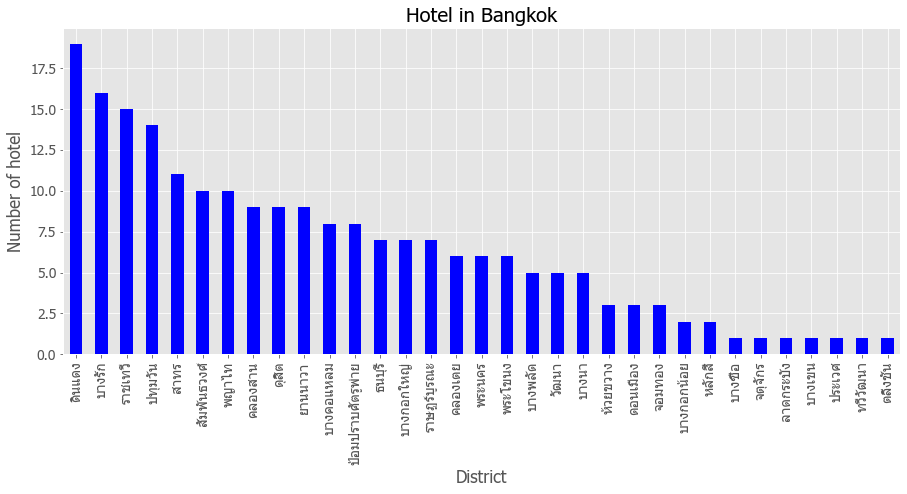

In [19]:
no_of_hotel.plot(kind='bar',  color='blue', figsize=(15, 6))

plt.xlabel('District') # add to x-label to the plot
plt.ylabel('Number of hotel') # add y-label to the plot
plt.title('Hotel in Bangkok') # add title to the plot

plt.show()

## Methodology

In this project will use one-hot encoding to categorize data and represents as numerical value of the dataset. Then will use K-Means technique to use to cluster district into 3 clusters based on their frequency of occurrence for hotel

### One-Hot Encoding

In [20]:
# one hot encoding
df_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['District'] = venues_df['District'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

print(df_onehot.shape)
df_onehot.head()

(4874, 218)


,District,Airport,Airport Lounge,Airport Service,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Astrologer,Athletics & Sports,...,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,บางบอน,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,บางบอน,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,บางบอน,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,บางบอน,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,บางบอน,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_grouped = df_onehot.groupby(["District"]).mean().reset_index()

print(df_grouped.shape)
df_grouped.head()

(50, 218)


,District,Airport,Airport Lounge,Airport Service,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Astrologer,Athletics & Sports,...,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,คลองสาน,0.0,0.0,0.0,0.0,0.01,0.01,0.04,0.0,0.0,...,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.00
1,คลองสามวา,0.0,0.0,0.0,0.0,0.00,0.00,0.01,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.01,0.00,0.00,0.02,0.01
2,คลองเตย,0.0,0.0,0.0,0.0,0.00,0.00,0.01,0.0,0.0,...,0.02,0.00,0.01,0.00,0.0,0.00,0.01,0.00,0.00,0.00
3,คันนายาว,0.0,0.0,0.0,0.0,0.00,0.00,0.05,0.0,0.0,...,0.00,0.02,0.00,0.00,0.0,0.01,0.00,0.00,0.00,0.00
4,จตุจักร,0.0,0.0,0.0,0.0,0.01,0.01,0.03,0.0,0.0,...,0.01,0.00,0.00,0.00,0.0,0.00,0.01,0.01,0.00,0.01


In [22]:
len(df_grouped[df_grouped["Hotel"] > 0])

33

In [23]:
df_mall = df_grouped[["District","Hotel"]]

### Cluster districts in Bangkok using K-Mean

In [24]:
# set number of clusters
kclusters = 3

df_clustering = df_mall.drop(["District"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 2, 1, 1, 1, 1, 0, 2, 1])

In [25]:
df_clustered = df_mall.copy()

# add clustering labels
df_clustered["Cluster"] = kmeans.labels_
df_clustered.head()

,District,Hotel,Cluster
0,คลองสาน,0.09,2
1,คลองสามวา,0.00,1
2,คลองเตย,0.06,2
3,คันนายาว,0.00,1
4,จตุจักร,0.01,1


In [26]:
# add latitude/longitude for each district
df_clustered = df_clustered.join(wiki_df.set_index("District"), on="District")

print(df_clustered.shape)
df_clustered.head()

(50, 10)


,District,Hotel,Cluster,DistrictEng,code,Postcode,Population,No_of_Subdistricts,Latitude,Longitude
0,คลองสาน,0.09,2,Khlong San,18,10600,76446,4,13.730278,100.509722
1,คลองสามวา,0.00,1,Khlong Sam Wa,46,10510,169489,5,13.859722,100.704167
2,คลองเตย,0.06,2,Khlong Toei,33,10110,109041,3,13.708056,100.583889
3,คันนายาว,0.00,1,Khan Na Yao,43,10230,88678,2,13.827100,100.674300
4,จตุจักร,0.01,1,Chatuchak,30,10900,160906,5,13.828611,100.559722


### Generate Cluster map

In [27]:

map_clusters = folium.Map(location=[bangkok.latitude, bangkok.longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['District'], df_clustered['Cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Result

We found that hotels are clustered using number of hotels in each district, so it can be classified to high, medium and low number of hotel in each area.

In [28]:
df_clustered.loc[df_clustered['Cluster'] == 0].head()

,District,Hotel,Cluster,DistrictEng,code,Postcode,Population,No_of_Subdistricts,Latitude,Longitude
7,ดินแดง,0.19,0,Din Daeng,26,10400,130220,2,13.769722,100.552778
22,บางรัก,0.16,0,Bang Rak,4,10500,45875,5,13.730833,100.524167
26,ปทุมวัน,0.14,0,Pathum Wan,7,10330,53263,4,13.744942,100.522200
35,ราชเทวี,0.15,0,Ratchathewi,37,10400,73035,4,13.758889,100.534444


In [29]:
df_clustered.loc[df_clustered['Cluster'] == 1].head()

,District,Hotel,Cluster,DistrictEng,code,Postcode,Population,No_of_Subdistricts,Latitude,Longitude
1,คลองสามวา,0.00,1,Khlong Sam Wa,46,10510,169489,5,13.859722,100.704167
3,คันนายาว,0.00,1,Khan Na Yao,43,10230,88678,2,13.827100,100.674300
4,จตุจักร,0.01,1,Chatuchak,30,10900,160906,5,13.828611,100.559722
5,จอมทอง,0.03,1,Chom Thong,35,10150,158005,4,13.677222,100.484722
6,ดอนเมือง,0.03,1,Don Mueang,36,10210,166261,3,13.913611,100.589722


In [30]:
df_clustered.loc[df_clustered['Cluster'] == 2].head()

,District,Hotel,Cluster,DistrictEng,code,Postcode,Population,No_of_Subdistricts,Latitude,Longitude
0,คลองสาน,0.09,2,Khlong San,18,10600,76446,4,13.730278,100.509722
2,คลองเตย,0.06,2,Khlong Toei,33,10110,109041,3,13.708056,100.583889
8,ดุสิต,0.09,2,Dusit,2,10300,107655,5,13.776944,100.520556
12,ธนบุรี,0.07,2,Thon Buri,15,10600,119708,7,13.725000,100.485833
14,บางกอกใหญ่,0.07,2,Bangkok Yai,16,10600,72321,2,13.722778,100.476389


In [31]:
df_clustered

,District,Hotel,Cluster,DistrictEng,code,Postcode,Population,No_of_Subdistricts,Latitude,Longitude
0,คลองสาน,0.090000,2,Khlong San,18,10600,76446,4,13.730278,100.509722
1,คลองสามวา,0.000000,1,Khlong Sam Wa,46,10510,169489,5,13.859722,100.704167
2,คลองเตย,0.060000,2,Khlong Toei,33,10110,109041,3,13.708056,100.583889
3,คันนายาว,0.000000,1,Khan Na Yao,43,10230,88678,2,13.827100,100.674300
4,จตุจักร,0.010000,1,Chatuchak,30,10900,160906,5,13.828611,100.559722
5,จอมทอง,0.030000,1,Chom Thong,35,10150,158005,4,13.677222,100.484722
6,ดอนเมือง,0.030000,1,Don Mueang,36,10210,166261,3,13.913611,100.589722
7,ดินแดง,0.190000,0,Din Daeng,26,10400,130220,2,13.769722,100.552778
8,ดุสิต,0.090000,2,Dusit,2,10300,107655,5,13.776944,100.520556
9,ตลิ่งชัน,0.010000,1,Taling Chan,19,10170,106604,6,13.776944,100.456667


## Conclusion

According to objective of this project to support decision making on planning to launch new hotel in Bangkok by gone through the identifying process of business problem, data acquisition, data extraction and data preparation and clustering data with machine learning by clustering data into 3 groups
The findings of this project will help the relevant stakeholders to capitalize on the opportunities on high potential locations while avoiding overcrowded area in their decisions to open a new hotel
